# Checkpoint 7 - Challenge
Now take your Keras skills and go build another neural network. Pick your data set, but it should be one of abstract types, possibly even nonnumeric, and use Keras to make five implementations of your network. Compare them both in computational complexity as well as in accuracy and given that tradeoff decide which one you like best.

Your dataset should be sufficiently large for a neural network to perform well (samples should really be in the thousands here) and try to pick something that takes advantage of neural networks’ ability to have both feature extraction and supervised capabilities, so don’t pick something with an easy to consume list of features already generated for you (though neural networks can still be useful in those contexts).

Note that if you want to use an unprocessed image dataset, scikit-image is a useful package for converting to importable numerics.

In [1]:
import os
os.chdir('C:\\Users\\M246047\\Documents\\Python')
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import re
import tensorflow
import keras

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import scipy.stats as stats

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop

# Import the backend
from keras import backend as K

Using TensorFlow backend.


In [2]:
churn = pd.read_csv('Bank_Churn.csv')
churn = pd.DataFrame(churn)
print(churn.columns)
print(churn.info())
churn.head(10)

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


I'll run one hot encoding for categorical variables Geography and Gender and then normalize the data and run it through neural networks.

In [3]:
# Creating dummy variables for Geography and Gender
churn = pd.concat([churn, pd.get_dummies(churn['Geography'])], axis=1)
churn = pd.concat([churn, pd.get_dummies(churn['Gender'])], axis=1)
churn.shape

(10000, 19)

In [4]:
# Dropping variables Geography and Gender as we now have dummies as well as variables that don't provide relavent information
churn.drop(columns=['Geography', 'Gender','RowNumber','CustomerId','Surname'], inplace=True)

In [5]:
# Checking the data types
for column in churn.columns:
    print(column, churn[column].dtype)

CreditScore int64
Age int64
Tenure int64
Balance float64
NumOfProducts int64
HasCrCard int64
IsActiveMember int64
EstimatedSalary float64
Exited int64
France uint8
Germany uint8
Spain uint8
Female uint8
Male uint8


In [7]:
# Checking normalization

features_to_test = churn[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']]
for feat in features_to_test:
    jb_stats = stats.jarque_bera(churn[feat])
    norm_stats = stats.normaltest(churn[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on CreditScore:
Jarque-Bera test statistics for CreditScore is 84.19832660649816 and p value is 0.0
Normality test statistics for CreditScore is 132.82837928588427 and p value is 1.434445056038405e-29

Testing for normality on Age:
Jarque-Bera test statistics for Age is 2513.842313254128 and p value is 0.0
Normality test statistics for Age is 1507.7908881363314 and p value is 0.0

Testing for normality on Tenure:
Jarque-Bera test statistics for Tenure is 565.9472939187292 and p value is 0.0
Normality test statistics for Tenure is 6481.918283079272 and p value is 0.0

Testing for normality on Balance:
Jarque-Bera test statistics for Balance is 957.3080391507327 and p value is 0.0
Normality test statistics for Balance is 62973.389518519696 and p value is 0.0

Testing for normality on NumOfProducts:
Jarque-Bera test statistics for NumOfProducts is 1067.3528830000523 and p value is 0.0
Normality test statistics for NumOfProducts is 832.9888632346675 and p value is 1.3

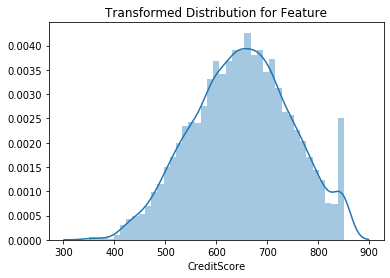

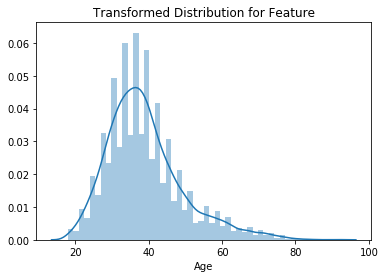

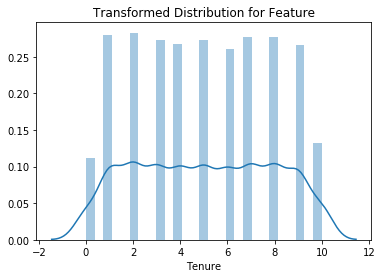

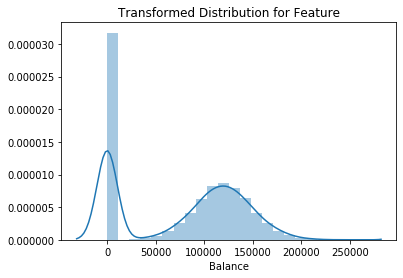

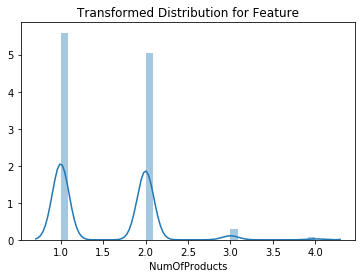

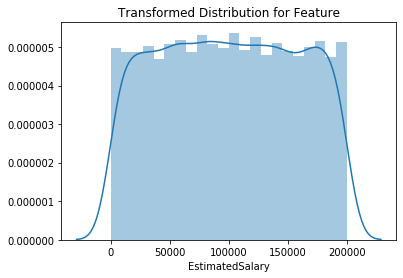

In [8]:
for feat in features_to_test:
    sns.distplot(churn[feat])
    plt.title('Transformed Distribution for Feature')
    plt.show()
    print('\n')

In [9]:
# Defining the target and variables
y = churn[['Exited']]
X = churn.drop('Exited', axis=1)

# normalize the data attributes
normalized_X = preprocessing.normalize(X)

# Creating training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.2)

In [10]:
print(X_train.shape)
print(X_test.shape)

(8000, 13)
(2000, 13)


In [11]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(64, activation='relu', input_shape=(13,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(2, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 5,186
Trainable params: 5,186
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: Error when checking target: expected dense_3 to have shape (2,) but got array with shape (1,)